# Classification on the ‘credit-g’ dataset using Logistic Regression and Decision Tree classification.

# Download Data:
You can download the dataset using the commands below  and see it’s description at https://www.openml.org/d/31

### Attribute description from https://www.openml.org/d/31

1. Status of existing checking account, in Deutsche Mark.
2. Duration in months
3. Credit history (credits taken, paid back duly, delays, critical accounts)
4. Purpose of the credit (car, television,...)
5. Credit amount
6. Status of savings account/bonds, in Deutsche Mark.
7. Present employment, in number of years.
8. Installment rate in percentage of disposable income
9. Personal status (married, single,...) and sex
10. Other debtors / guarantors
11. Present residence since X years
12. Property (e.g. real estate)
13. Age in years
14. Other installment plans (banks, stores)
15. Housing (rent, own,...)
16. Number of existing credits at this bank
17. Job
18. Number of people being liable to provide maintenance for
19. Telephone (yes,no)
20. Foreign worker (yes,no)

## **Importing all the libraries**

In [ ]:
import warnings
warnings.filterwarnings(action='once')

In [ ]:
%%capture
!pip install feature_engine

In [ ]:
%%capture
!pip install -U scikit-learn

In [ ]:
import sklearn
import feature_engine

/usr/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [ ]:
print(sklearn.__version__)
print(feature_engine.__version__)

1.0
1.1.2


In [ ]:
# For DataFrames and manipulations
import pandas as pd
import numpy as np
import scipy.stats as stats

# For data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as po
import plotly.graph_objects as go

%matplotlib inline
import plotly.io as pio
pio.renderers.default = 'colab'

# For splitting the dataset
from sklearn.model_selection import train_test_split

# drop arbitrary features
from sklearn.datasets import fetch_openml

# For categorical variables
from feature_engine.encoding import OneHotEncoder
from feature_engine.encoding import RareLabelEncoder
from feature_engine.encoding import DecisionTreeEncoder
from feature_engine.encoding import MeanEncoder

# For scaling the data
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from feature_engine.transformation import YeoJohnsonTransformer
from feature_engine.transformation import LogTransformer

# DIscretization
from sklearn.preprocessing import KBinsDiscretizer

# Handling Outliers
from feature_engine.outliers import Winsorizer

# feature engine wrapper 
from feature_engine.wrappers import SklearnTransformerWrapper

# Using KNN classification for our data
from sklearn.neighbors import KNeighborsClassifier

# creating pipelines 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Hyper parameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

# learning Curves
from sklearn.model_selection import learning_curve

# draws a confusion matrix
from sklearn.metrics import plot_confusion_matrix 

# save and load models
import joblib

# Pathlib to navigate file system
from pathlib import Path



/usr/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/local/lib/python3.7/dist-packages/jsonschema/compat.py:6: DeprecationWarning:

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working

/usr/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject



## Mount Google Drive, Import Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
save_model_folder  = Path('/content/drive/MyDrive/HW')

# **Import the dataset**

In [ ]:
# Load data from  https://www.openml.org/d/31
X, y = fetch_openml("credit-g", version=1, as_frame=True, return_X_y=True)

In [ ]:
X.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
0,<0,6.0,critical/other existing credit,radio/tv,1169.0,no known savings,>=7,4.0,male single,none,4.0,real estate,67.0,none,own,2.0,skilled,1.0,yes,yes
1,0<=X<200,48.0,existing paid,radio/tv,5951.0,<100,1<=X<4,2.0,female div/dep/mar,none,2.0,real estate,22.0,none,own,1.0,skilled,1.0,none,yes
2,no checking,12.0,critical/other existing credit,education,2096.0,<100,4<=X<7,2.0,male single,none,3.0,real estate,49.0,none,own,1.0,unskilled resident,2.0,none,yes
3,<0,42.0,existing paid,furniture/equipment,7882.0,<100,4<=X<7,2.0,male single,guarantor,4.0,life insurance,45.0,none,for free,1.0,skilled,2.0,none,yes
4,<0,24.0,delayed previously,new car,4870.0,<100,1<=X<4,3.0,male single,none,4.0,no known property,53.0,none,for free,2.0,skilled,2.0,none,yes


# Function for learning curves: 
The function below has been taken from sklearn official documentation: https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py

In [ ]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.2, 1.0, 5)):
    """
    Generate 2 plots: the test and training learning curve, the training
    samples vs fit times curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True,
                       random_state=123)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    return plt

# EDA

## Check Data

In [ ]:
# check the top 5 rows
X.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
0,<0,6.0,critical/other existing credit,radio/tv,1169.0,no known savings,>=7,4.0,male single,none,4.0,real estate,67.0,none,own,2.0,skilled,1.0,yes,yes
1,0<=X<200,48.0,existing paid,radio/tv,5951.0,<100,1<=X<4,2.0,female div/dep/mar,none,2.0,real estate,22.0,none,own,1.0,skilled,1.0,none,yes
2,no checking,12.0,critical/other existing credit,education,2096.0,<100,4<=X<7,2.0,male single,none,3.0,real estate,49.0,none,own,1.0,unskilled resident,2.0,none,yes
3,<0,42.0,existing paid,furniture/equipment,7882.0,<100,4<=X<7,2.0,male single,guarantor,4.0,life insurance,45.0,none,for free,1.0,skilled,2.0,none,yes
4,<0,24.0,delayed previously,new car,4870.0,<100,1<=X<4,3.0,male single,none,4.0,no known property,53.0,none,for free,2.0,skilled,2.0,none,yes


In [ ]:
# check all the columns of the data
X.columns

Index(['checking_status', 'duration', 'credit_history', 'purpose',
       'credit_amount', 'savings_status', 'employment',
       'installment_commitment', 'personal_status', 'other_parties',
       'residence_since', 'property_magnitude', 'age', 'other_payment_plans',
       'housing', 'existing_credits', 'job', 'num_dependents', 'own_telephone',
       'foreign_worker'],
      dtype='object')

In [ ]:
# check the data type for the columns
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   checking_status         1000 non-null   category
 1   duration                1000 non-null   float64 
 2   credit_history          1000 non-null   category
 3   purpose                 1000 non-null   category
 4   credit_amount           1000 non-null   float64 
 5   savings_status          1000 non-null   category
 6   employment              1000 non-null   category
 7   installment_commitment  1000 non-null   float64 
 8   personal_status         1000 non-null   category
 9   other_parties           1000 non-null   category
 10  residence_since         1000 non-null   float64 
 11  property_magnitude      1000 non-null   category
 12  age                     1000 non-null   float64 
 13  other_payment_plans     1000 non-null   category
 14  housing                 1

In [ ]:
# Identify Columns that Contain a Single value and delete the columns which have single values 
X.nunique()

checking_status             4
duration                   33
credit_history              5
purpose                    10
credit_amount             921
savings_status              5
employment                  5
installment_commitment      4
personal_status             4
other_parties               3
residence_since             4
property_magnitude          4
age                        53
other_payment_plans         3
housing                     3
existing_credits            4
job                         4
num_dependents              2
own_telephone               2
foreign_worker              2
dtype: int64

Out of all the columns, there is no column with a single value and thus we don't delete any of them.

In [ ]:
# We will use describe function and then take the transpose for better visualization
X.describe().T

,count,mean,std,min,25%,50%,75%,max
duration,1000.0,20.903,12.058814,4.0,12.0,18.0,24.00,72.0
credit_amount,1000.0,3271.258,2822.736876,250.0,1365.5,2319.5,3972.25,18424.0
installment_commitment,1000.0,2.973,1.118715,1.0,2.0,3.0,4.00,4.0
residence_since,1000.0,2.845,1.103718,1.0,2.0,3.0,4.00,4.0
age,1000.0,35.546,11.375469,19.0,27.0,33.0,42.00,75.0
existing_credits,1000.0,1.407,0.577654,1.0,1.0,1.0,2.00,4.0
num_dependents,1000.0,1.155,0.362086,1.0,1.0,1.0,1.00,2.0


In [ ]:
# To check the duplicates of the data
dups = X.duplicated()
# report if there are any duplicates
print(dups.any())
# list all duplicate rows
print(X[dups])

False
Empty DataFrame
Columns: [checking_status, duration, credit_history, purpose, credit_amount, savings_status, employment, installment_commitment, personal_status, other_parties, residence_since, property_magnitude, age, other_payment_plans, housing, existing_credits, job, num_dependents, own_telephone, foreign_worker]
Index: []


From the given results, we can check that there are no duplicates in our data

## Missing Values

In [ ]:
# check missing values in data
X.isna()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
996,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
997,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
998,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [ ]:
# calculate % of mssing values for each column
X.isna().mean()* 100

checking_status           0.0
duration                  0.0
credit_history            0.0
purpose                   0.0
credit_amount             0.0
savings_status            0.0
employment                0.0
installment_commitment    0.0
personal_status           0.0
other_parties             0.0
residence_since           0.0
property_magnitude        0.0
age                       0.0
other_payment_plans       0.0
housing                   0.0
existing_credits          0.0
job                       0.0
num_dependents            0.0
own_telephone             0.0
foreign_worker            0.0
dtype: float64

## Identify numerical, categorical and discrete variables
Since EDA steps can be different depending on type of variables. Let us first create list of different type of variables.

In [ ]:
# Create a list of categorical variables
# Since the dtype of categorical variable is Object we can compare the values with 'O' 
categorical = [var for var in X.columns if X[var].dtype.name == 'category']

# Create a list of discrete variables
# we do not want to consider Exited as this is target variable
discrete = [
    var for var in X.columns if X[var].dtype.name != 'category'
    and len(X[var].unique()) < 20
]

# Create a list of continuous Variables
continuous = [
    var for var in X.columns if X[var].dtype.name != 'category'
    if var not in discrete
]

In [ ]:
# check continous Variables
continuous

['duration', 'credit_amount', 'age']

In [ ]:
# check categorical variables
categorical

['checking_status',
 'credit_history',
 'purpose',
 'savings_status',
 'employment',
 'personal_status',
 'other_parties',
 'property_magnitude',
 'other_payment_plans',
 'housing',
 'job',
 'own_telephone',
 'foreign_worker']

In [ ]:
# check discrete variables
discrete

['installment_commitment',
 'residence_since',
 'existing_credits',
 'num_dependents']

###  Check unique values for variables

In [ ]:
# Check number of unique values for discrete variables
total_unique_values= X[discrete].nunique()
for key, value in total_unique_values.items():
    if value > 0:
        print(key,":",value)

installment_commitment : 4
residence_since : 4
existing_credits : 4
num_dependents : 2


In [ ]:
# check values for discrete variables
for var in discrete:
    print(var, X[var].unique(), '\n')

installment_commitment [4. 2. 3. 1.] 

residence_since [4. 2. 3. 1.] 

existing_credits [2. 1. 3. 4.] 

num_dependents [1. 2.] 



In [ ]:
# Check number of unique values for continuous variables
total_unique_values= X[continuous].nunique()
for key,value in total_unique_values.items():
    if value >0:
        print(key,":",value)

duration : 33
credit_amount : 921
age : 53


In [ ]:
# check values for continuous variables
# we will check the first 20 values
for var in continuous:
    print(var, X[var].unique()[0:20], '\n')

duration [ 6. 48. 12. 42. 24. 36. 30. 15.  9. 10.  7. 60. 18. 45. 11. 27.  8. 54.
 20. 14.] 

credit_amount [ 1169.  5951.  2096.  7882.  4870.  9055.  2835.  6948.  3059.  5234.
  1295.  4308.  1567.  1199.  1403.  1282.  2424.  8072. 12579.  3430.] 

age [67. 22. 49. 45. 53. 35. 61. 28. 25. 24. 60. 32. 44. 31. 48. 26. 36. 39.
 42. 34.] 



In [ ]:
# Check number of unique values for categorical variables
total_unique_values= X[categorical].nunique()
for key,value in total_unique_values.items():
    if value >0:
        print(key,":",value)

checking_status : 4
credit_history : 5
purpose : 10
savings_status : 5
employment : 5
personal_status : 4
other_parties : 3
property_magnitude : 4
other_payment_plans : 3
housing : 3
job : 4
own_telephone : 2
foreign_worker : 2


In [ ]:
# check values for categorical variables
for var in categorical:
    print(var, X[var].unique(), '\n')

checking_status ['<0', '0<=X<200', 'no checking', '>=200']
Categories (4, object): ['<0', '0<=X<200', 'no checking', '>=200'] 

credit_history ['critical/other existing credit', 'existing paid', 'delayed previously', 'no credits/all paid', 'all paid']
Categories (5, object): ['critical/other existing credit', 'existing paid', 'delayed previously',
                         'no credits/all paid', 'all paid'] 

purpose ['radio/tv', 'education', 'furniture/equipment', 'new car', 'used car', 'business', 'domestic appliance', 'repairs', 'other', 'retraining']
Categories (10, object): ['radio/tv', 'education', 'furniture/equipment', 'new car', ...,
                          'domestic appliance', 'repairs', 'other', 'retraining'] 

savings_status ['no known savings', '<100', '500<=X<1000', '>=1000', '100<=X<500']
Categories (5, object): ['no known savings', '<100', '500<=X<1000', '>=1000', '100<=X<500'] 

employment ['>=7', '1<=X<4', '4<=X<7', 'unemployed', '<1']
Categories (5, object): ['>=7'

In [ ]:
#Let's check the columns with categorical variables
X[categorical].head().T


,0,1,2,3,4
checking_status,<0,0<=X<200,no checking,<0,<0
credit_history,critical/other existing credit,existing paid,critical/other existing credit,existing paid,delayed previously
purpose,radio/tv,radio/tv,education,furniture/equipment,new car
savings_status,no known savings,<100,<100,<100,<100
employment,>=7,1<=X<4,4<=X<7,4<=X<7,1<=X<4
personal_status,male single,female div/dep/mar,male single,male single,male single
other_parties,none,none,none,guarantor,none
property_magnitude,real estate,real estate,real estate,life insurance,no known property
other_payment_plans,none,none,none,none,none
housing,own,own,own,for free,for free


## Check Variable Distributions

### Categorical Varibles

#### Frequency distribution of categorical variables and rare categories

In [ ]:
def check_rare(var):
  cat_freq = 100 * X[var].value_counts(normalize=True)
  fig = cat_freq.sort_values(ascending=False).plot.bar()
  fig.axhline(y=5, color='red')
  fig.set_ylabel('category percentage frequency')
  fig.set_xlabel(var)
  fig.set_title('Identifying Rare Categories')
  plt.show()

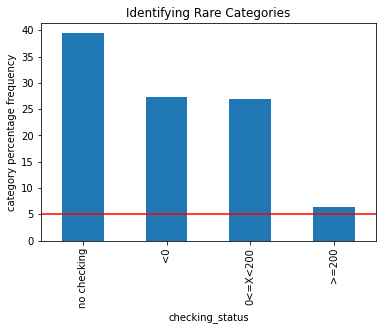

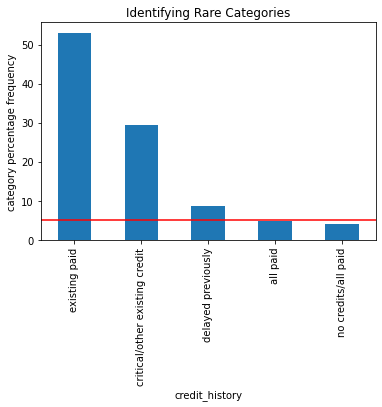

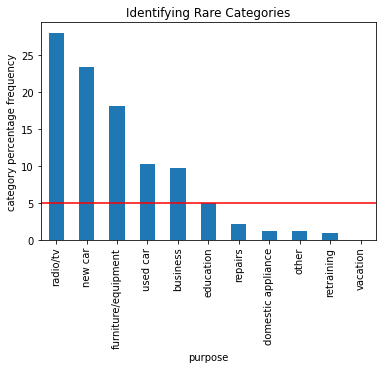

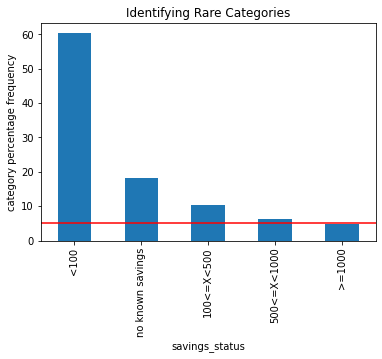

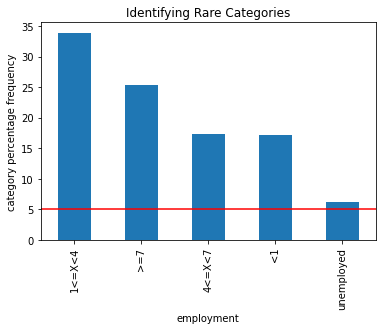

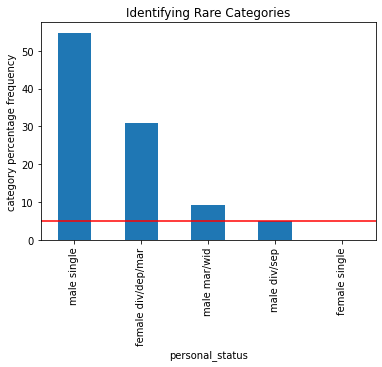

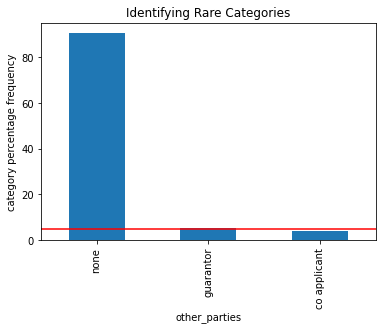

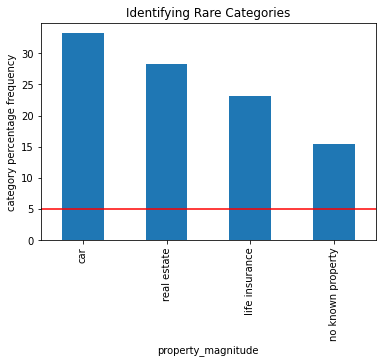

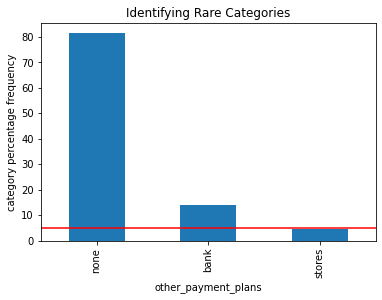

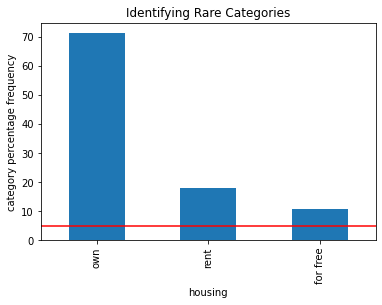

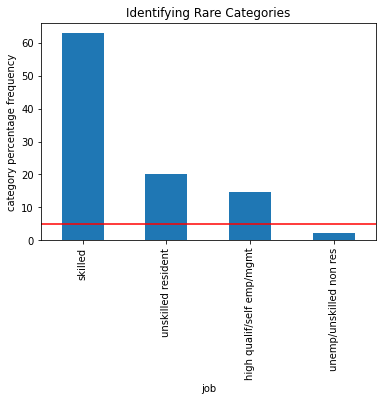

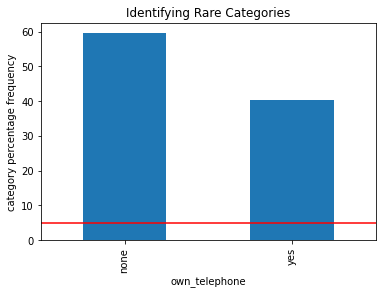

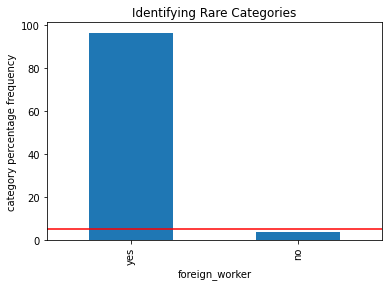

In [ ]:
for var in categorical:
  check_rare(var)

**From the above graph, we can see that we need to do rare label emcoding for following variables: 'credit_history', 'purpose', 'savings_status', 'personal_status', 'other_parties', other_payment_plans', 'job'**

### Check distribution of target variable

In [ ]:
print(f"{100 * y.value_counts(normalize=True)} ")

good    70.0
bad     30.0
Name: class, dtype: float64 


From the above analysis, we can observe that 70% of the the data is classified as good credit risk and 30% of the data is classified as bad credit risk. We can see that the dataset is imbalanced i.e. we have far more observation from one class or label. We will see how to address this issue later in the course.

### Distribution of continuous and discrete variables

In [ ]:
def diagnostic_plots(df, variable):
    # function takes a dataframe (df) and
    # the variable of interest as arguments

    # define figure size
    plt.figure(figsize=(16, 4))

    # histogram
    # plt.subplot(num rows, num columns, index)
    plt.subplot(1, 3, 1)
    sns.histplot(df[variable], bins=30)
    plt.title('Histogram')

    # boxplot
    # plt.subplot(num rows, num columns, index)
    plt.subplot(1, 3, 2)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot')

    # plt.subplot(num rows, num columns, index)
    plt.subplot(1, 3, 3)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.title('Q-Q plot')

    plt.show()

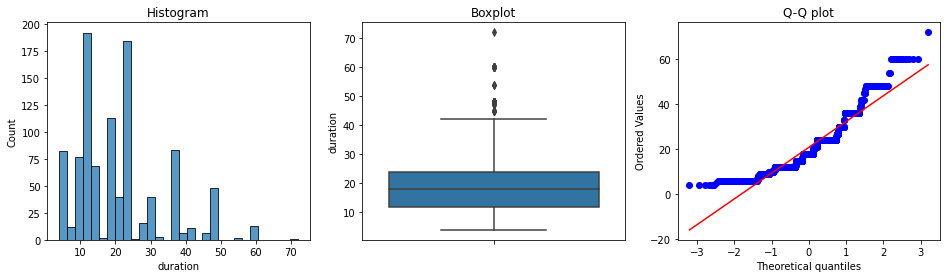

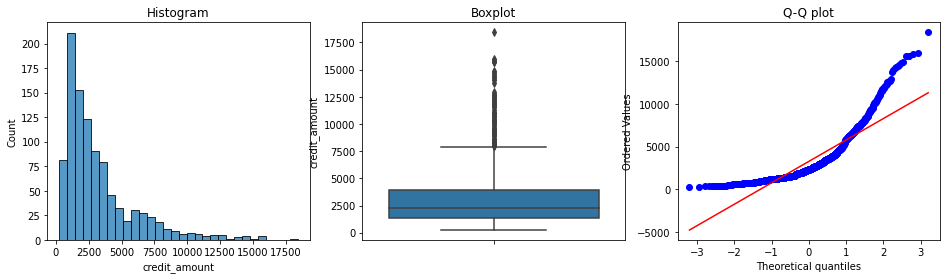

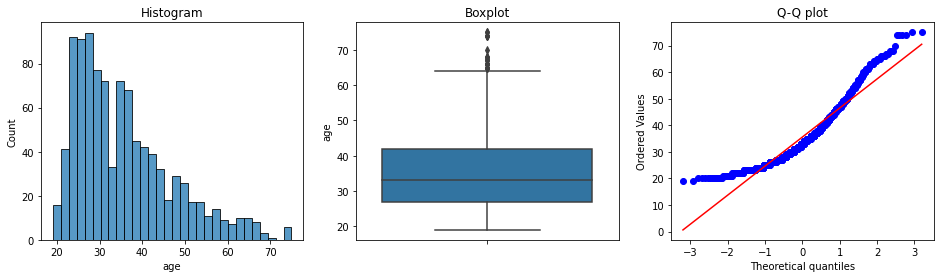

In [ ]:
for var in continuous:
    diagnostic_plots(X, var)

**All the three continuous variables are skewed. None of these variables have zero or negative values. We can use any of the following transformations - logartithmic, yeo-johnson or boxplot for these variabes.**

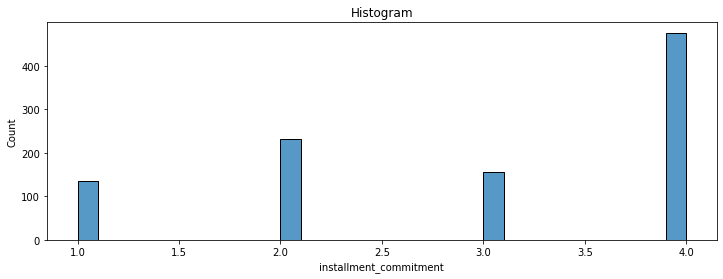

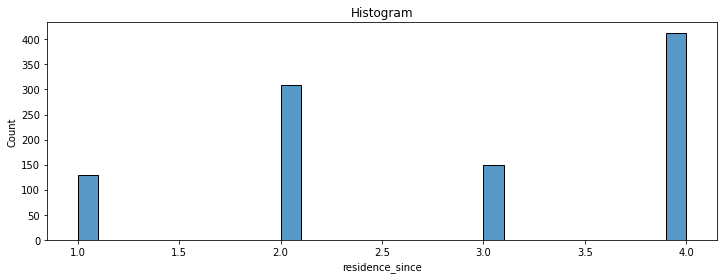

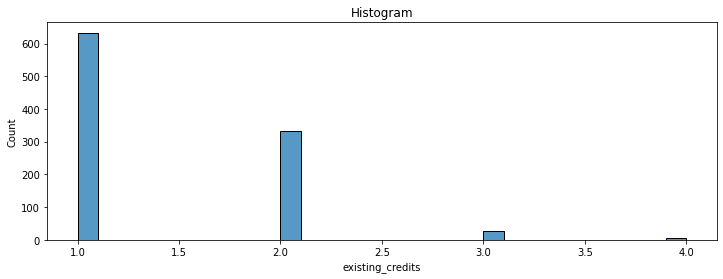

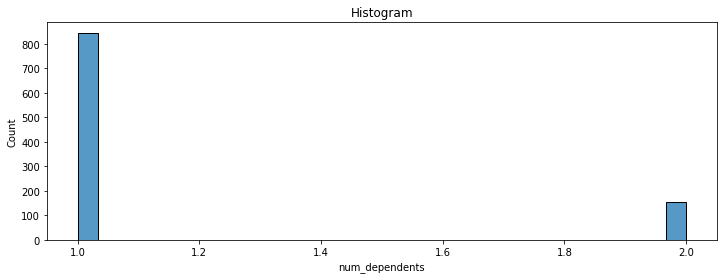

In [ ]:
# histograms for discrete variables
for var in discrete:
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 1, 1)
    sns.histplot(X[var], bins=30)
    plt.title('Histogram')

From the above graphs, it seems that these variables were continuos varibles. These have allready been discretized uisng equal width method.

## **Visualizing Relationships between variables**

### Correlation matrix

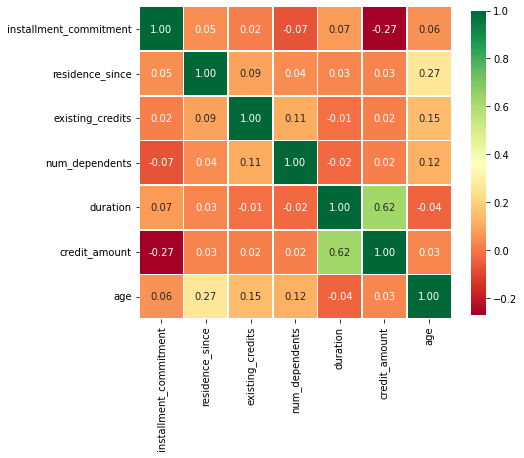

In [ ]:
# We can check the correlation between every pair of attributes
# The correlation will be generated for the numerical data only
# we will use df.corr() to et correlatons and then use sns.heatmap to print the cprrelation matrix
corrmat = X[discrete + continuous].corr().round(2)
top_corr_features = corrmat.index
plt.figure(figsize=(7, 7))
sns.heatmap(X[top_corr_features].corr(),annot=True, square=True, fmt='.2f', 
            cbar_kws={"shrink": .80}, linewidths=.5, cmap='RdYlGn');

In [ ]:
df = pd.concat([X, y], axis = 1)


In [ ]:
df.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6.0,critical/other existing credit,radio/tv,1169.0,no known savings,>=7,4.0,male single,none,4.0,real estate,67.0,none,own,2.0,skilled,1.0,yes,yes,good
1,0<=X<200,48.0,existing paid,radio/tv,5951.0,<100,1<=X<4,2.0,female div/dep/mar,none,2.0,real estate,22.0,none,own,1.0,skilled,1.0,none,yes,bad
2,no checking,12.0,critical/other existing credit,education,2096.0,<100,4<=X<7,2.0,male single,none,3.0,real estate,49.0,none,own,1.0,unskilled resident,2.0,none,yes,good
3,<0,42.0,existing paid,furniture/equipment,7882.0,<100,4<=X<7,2.0,male single,guarantor,4.0,life insurance,45.0,none,for free,1.0,skilled,2.0,none,yes,good
4,<0,24.0,delayed previously,new car,4870.0,<100,1<=X<4,3.0,male single,none,4.0,no known property,53.0,none,for free,2.0,skilled,2.0,none,yes,bad


In [ ]:
df.rename({'class': 'target'}, axis = 1, inplace=True)

In [ ]:
df['target'] = df['target'].map({'good':0, 'bad':1})

In [ ]:
df = df.astype({'target': 'int32'})

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   checking_status         1000 non-null   category
 1   duration                1000 non-null   float64 
 2   credit_history          1000 non-null   category
 3   purpose                 1000 non-null   category
 4   credit_amount           1000 non-null   float64 
 5   savings_status          1000 non-null   category
 6   employment              1000 non-null   category
 7   installment_commitment  1000 non-null   float64 
 8   personal_status         1000 non-null   category
 9   other_parties           1000 non-null   category
 10  residence_since         1000 non-null   float64 
 11  property_magnitude      1000 non-null   category
 12  age                     1000 non-null   float64 
 13  other_payment_plans     1000 non-null   category
 14  housing                 1

In [ ]:
df.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,target
0,<0,6.0,critical/other existing credit,radio/tv,1169.0,no known savings,>=7,4.0,male single,none,4.0,real estate,67.0,none,own,2.0,skilled,1.0,yes,yes,0
1,0<=X<200,48.0,existing paid,radio/tv,5951.0,<100,1<=X<4,2.0,female div/dep/mar,none,2.0,real estate,22.0,none,own,1.0,skilled,1.0,none,yes,1
2,no checking,12.0,critical/other existing credit,education,2096.0,<100,4<=X<7,2.0,male single,none,3.0,real estate,49.0,none,own,1.0,unskilled resident,2.0,none,yes,0
3,<0,42.0,existing paid,furniture/equipment,7882.0,<100,4<=X<7,2.0,male single,guarantor,4.0,life insurance,45.0,none,for free,1.0,skilled,2.0,none,yes,0
4,<0,24.0,delayed previously,new car,4870.0,<100,1<=X<4,3.0,male single,none,4.0,no known property,53.0,none,for free,2.0,skilled,2.0,none,yes,1


In [ ]:
def plot_percent_credit_risk_by_category(category):
  percent_credit_risk_by_category =  df.groupby(category).target.mean().round(2).reset_index()

  plot_data = [
      go.Bar(
          x = percent_credit_risk_by_category[category],
          y = percent_credit_risk_by_category['target'],
          width = [0.3]*len(percent_credit_risk_by_category),
         
          marker = dict(
          color = percent_credit_risk_by_category['target'])
          
      )
  ]
  # Giving the layout to the bar graph
  plot_layout = go.Layout(
          
          xaxis = {"type": "category","title":category},
          # The title for y- axis is Credit Risk
          yaxis = {"title": "Credit"},
          title = f'Credit Risk by {category}',
          plot_bgcolor  = 'rgb(243,243,243)',
          paper_bgcolor  = 'rgb(243,243,243)',
          autosize = True,
          width =700,
          height=400,
      )
  #plotting the data with given layout
  fig = go.Figure(data=plot_data, layout=plot_layout, )
  po.iplot(fig)

In [ ]:
for category in categorical + discrete:
  plot_percent_credit_risk_by_category(category)

## **Conclusions:** 

1. We do not have any missing values or single value columns
2. We have categorical variables in the data frame that should be converted into numerical values before we run our model. Hence we need to do encoding of categorical variables.
3. Further, we need to do rare label encoding for following variables: 'credit_history', 'purpose', 'savings_status', 'personal_status', 'other_parties', other_payment_plans', 'job'. 
4. From distributions of age, duration and amount, we can see that all three of these variables are skewed. We need to do transformation (like logarithmic, boxplot or yeojohnson) for these variables. 
5. From the graphs of discrete variables, it seems that these variables were continuos varibles. These have allredy been have been discretized uisng equal width method. 
6. From the relationship between target variables and discrete variables - we can see that for certain variables the relationship is not monotonous. In this case onehot encoding or mean encoding/decision tree encoding might help.
6. Finally we will need to make sure that the continuos variables have same scale. We will need to do feature scaling for continuos variables.

**Preprocessing Steps:**

Pipeline 1: 

1. Rare label encoding. 
2. One hot encoding for categorical + discrete variables 
3. Log transformation for continuos variables
4. Scaling for continuous variables.

Pipeline 2:
Replace One hot enoding with Decision Tree encoding for categorical and discrete variables.

# Complete Pipeline

## Split Data

In [ ]:
# before doing any data cleaning step we need to first split the data into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=123, stratify =y)

In [ ]:
X_train.head()

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
356,no checking,12.0,critical/other existing credit,radio/tv,2331.0,no known savings,>=7,1.0,male single,co applicant,4.0,real estate,49.0,none,own,1.0,skilled,1.0,yes,yes
344,>=200,10.0,existing paid,new car,3949.0,<100,<1,1.0,male single,guarantor,1.0,life insurance,37.0,none,own,1.0,unskilled resident,2.0,none,yes
236,0<=X<200,6.0,existing paid,new car,14555.0,no known savings,unemployed,1.0,male single,none,2.0,life insurance,23.0,none,own,1.0,unemp/unskilled non res,1.0,yes,yes
699,>=200,15.0,existing paid,education,1905.0,<100,>=7,4.0,male single,none,4.0,car,40.0,none,rent,1.0,high qualif/self emp/mgmt,1.0,yes,yes
424,0<=X<200,12.0,existing paid,furniture/equipment,2762.0,no known savings,>=7,1.0,female div/dep/mar,none,2.0,life insurance,25.0,bank,own,1.0,skilled,1.0,yes,yes


In [ ]:
X_train.nunique()

checking_status             4
duration                   33
credit_history              5
purpose                    10
credit_amount             629
savings_status              5
employment                  5
installment_commitment      4
personal_status             4
other_parties               3
residence_since             4
property_magnitude          4
age                        52
other_payment_plans         3
housing                     3
existing_credits            4
job                         4
num_dependents              2
own_telephone               2
foreign_worker              2
dtype: int64

In [ ]:
y_train

356    good
344    good
236     bad
699    good
424     bad
       ... 
124     bad
923    good
362    good
217    good
200    good
Name: class, Length: 670, dtype: category
Categories (2, object): ['good', 'bad']

In [ ]:
print(f'Length of X_train: {len(X_train)}')
print(f'Length of X_test: {len(X_test)}')

Length of X_train: 670
Length of X_test: 330


In [ ]:
print(f'Length of y_train: {len(y_train)}')
print(f'Length of y_test: {len(y_test)}')

Length of y_train: 670
Length of y_test: 330


In [ ]:
import warnings
warnings.filterwarnings(action='once')

## Pipeline 1

Create a pipeline with following steps:

1. 'rare_label_encoder', variables =  var_rare_labels
2. 'One_hot_encoding', variables= categorical+discrete,
3. 'log_transformer', variables = continuous
4. 'scalar',StandardScaler(), variables = continuous
5. KNeighborsClassifier())


In [ ]:
var_rare_labels= [
 'credit_history',
 'purpose',
 'savings_status',
 'personal_status',
 'other_parties',
 'other_payment_plans',
 'job',
]

In [ ]:
continuous

['duration', 'credit_amount', 'age']

In [ ]:
discrete

['installment_commitment',
 'residence_since',
 'existing_credits',
 'num_dependents']

In [ ]:
categorical

['checking_status',
 'credit_history',
 'purpose',
 'savings_status',
 'employment',
 'personal_status',
 'other_parties',
 'property_magnitude',
 'other_payment_plans',
 'housing',
 'job',
 'own_telephone',
 'foreign_worker']

##**1** - Create the pipeline using feature engine.

In [ ]:
credit_risk_pipeline_1 = Pipeline([                           

   
    ('rare_label_encoder',
      RareLabelEncoder(tol=0.05, n_categories=2, variables=var_rare_labels,
                           replace_with='Rare')),

    ('one_hot_encoder',
      OneHotEncoder(variables=categorical + discrete
                    ,drop_last= True, ignore_format=True)),

    ('log_transformer',
     LogTransformer(variables = continuous)), 
    
    ('scalar',
      SklearnTransformerWrapper(StandardScaler(), variables = continuous)),
    
    ('knn',
     KNeighborsClassifier())
])

## **2**: Hyperparameter Tuning - Round 1

In [ ]:
# You will now create the paramtyer grid and do gridsearch. You will only tune n_neighbors of KNeighborsClassifier.
# In the first round use values from 1 to 5 (both included). Use step size of 1.

param_grid_1 = { 'knn__n_neighbors':  range(1, 6, 1)}
    
model = Pipeline([('knn', KNeighborsClassifier())])

# now we set up the grid search with cross-validation
grid_knn_1 = GridSearchCV(credit_risk_pipeline_1, param_grid_1,
                           cv=5, return_train_score= True)


In [ ]:
# fit the grid on training data 
grid_knn_1.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:442: UserWarning:

X does not have valid feature names, but KNeighborsClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:442: UserWarning:

X does not have valid feature names, but KNeighborsClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:442: UserWarning:

X does not have valid feature names, but KNeighborsClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:442: UserWarning:

X does not have valid feature names, but KNeighborsClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:442: UserWarning:

X does not have valid feature names, but KNeighborsClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:442: UserWarning:

X does not have valid feature names, but KNeighborsClassifier was fitted with feature names

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('rare_label_encoder',
                                        RareLabelEncoder(n_categories=2,
                                                         variables=['credit_history',
                                                                    'purpose',
                                                                    'savings_status',
                                                                    'personal_status',
                                                                    'other_parties',
                                                                    'other_payment_plans',
                                                                    'job'])),
                                       ('one_hot_encoder',
                                        OneHotEncoder(drop_last=True,
                                                      ignore_format=True,
                                                   

In [ ]:
# check the best_parameters from GridSearchCv for your model
print(grid_knn_1.best_params_)

{'knn__n_neighbors': 5}


In [ ]:
# Here  save_model_folder is folder where I have saved models. Change that to appropriate location. 
# This variable is defined in section Mount Google Drive, Import Data

# specify the file to save the best estimator
file_best_estimator_round1 = save_model_folder / 'knn_round1_best_estimator.pkl'

# specify the file to save complete grid results
file_complete_grid_round1 = save_model_folder / 'knn_round1_complete_grid.pkl'

In [ ]:
# save the best estimator
joblib.dump(grid_knn_1.best_estimator_, file_best_estimator_round1)

# save complete grid results
joblib.dump(grid_knn_1, file_complete_grid_round1)

['/content/drive/MyDrive/HW/knn_round1_complete_grid.pkl']

In [ ]:
# load  the best estimator
loaded_best_estimator_round1 = joblib.load(file_best_estimator_round1)

# load complete grid results
loaded_complete_grid_round1 = joblib.load(file_complete_grid_round1)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

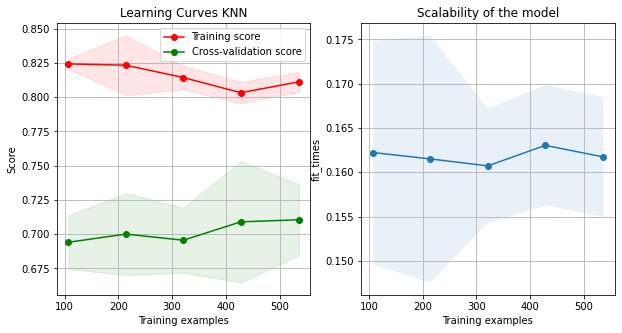

In [ ]:
# plot learning curves
# Notice that we are using the best estimator
plot_learning_curve(loaded_best_estimator_round1, 'Learning Curves KNN', X_train, y_train, n_jobs=-1)

In [ ]:
# Check the train scores
# to check the train scores we will use loaded best estinator

print(loaded_best_estimator_round1.score(X_train,y_train))

# check the cross validation score
# To check the cross validation score we need to use the loaded complete grid results

print(loaded_complete_grid_round1 .best_score_)

0.8059701492537313
0.7104477611940299


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:442: UserWarning:

X does not have valid feature names, but KNeighborsClassifier was fitted with feature names



- **Conclusions from Learning curves?**
- If the model is underfitting then we do not need round 2. This is because if it is underfitting then we need to increase model complexity. Since we are using n_neighbors from 1 to 5 (both included), we cannot increase model complexity further.
- If model is overfitting then specify higher ranges of n_neighbors. Use values of n_neighbors from 6 to 20 in next round


### Conclusion:
1) From the above learning cruves it is clear that the training curve is increasing linearly as CV score increases, it may cause overfitting. 

Let us increase the range from 6 to 20 and check for better number of neighbours

## **3:** Hyperparameter Tuning - Round 2

- If round2 is required then repeat all the steps of round 1. **Again only tune n_neighbors**. Use values in the range (6, 20). Use step size of 1.


In [ ]:

param_grid_2 = { 'knn__n_neighbors':  range(6, 21, 1)}
    
model_1 = Pipeline([('knn', KNeighborsClassifier())])

# now we set up the grid search with cross-validation
grid_knn_2 = GridSearchCV(credit_risk_pipeline_1, param_grid_2,
                           cv=5, return_train_score= True)


In [ ]:
# fit the grid on training data 
grid_knn_2.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:442: UserWarning:

X does not have valid feature names, but KNeighborsClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:442: UserWarning:

X does not have valid feature names, but KNeighborsClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:442: UserWarning:

X does not have valid feature names, but KNeighborsClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:442: UserWarning:

X does not have valid feature names, but KNeighborsClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:442: UserWarning:

X does not have valid feature names, but KNeighborsClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:442: UserWarning:

X does not have valid feature names, but KNeighborsClassifier was fitted with feature names

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('rare_label_encoder',
                                        RareLabelEncoder(n_categories=2,
                                                         variables=['credit_history',
                                                                    'purpose',
                                                                    'savings_status',
                                                                    'personal_status',
                                                                    'other_parties',
                                                                    'other_payment_plans',
                                                                    'job'])),
                                       ('one_hot_encoder',
                                        OneHotEncoder(drop_last=True,
                                                      ignore_format=True,
                                                   

In [ ]:
# check the best_parameters from GridSearchCv for your model
print(grid_knn_2.best_params_)

{'knn__n_neighbors': 8}


In [ ]:
# Here  save_model_folder is folder where I have saved models. Change that to appropriate location. 
# This variable is defined in section Mount Google Drive, Import Data

# specify the file to save the best estimator
file_best_estimator_round2 = save_model_folder / 'knn_round1_best_estimator_2.pkl'

# specify the file to save complete grid results
file_complete_grid_round2 = save_model_folder / 'knn_round1_complete_grid_2.pkl'

In [ ]:
# save the best estimator
joblib.dump(grid_knn_2.best_estimator_, file_best_estimator_round2)

# save complete grid results
joblib.dump(grid_knn_2, file_complete_grid_round2)

['/content/drive/MyDrive/HW/knn_round1_complete_grid_2.pkl']

In [ ]:
# load  the best estimator
loaded_best_estimator_round2 = joblib.load(file_best_estimator_round2)

# load complete grid results
loaded_complete_grid_round2 = joblib.load(file_complete_grid_round2)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

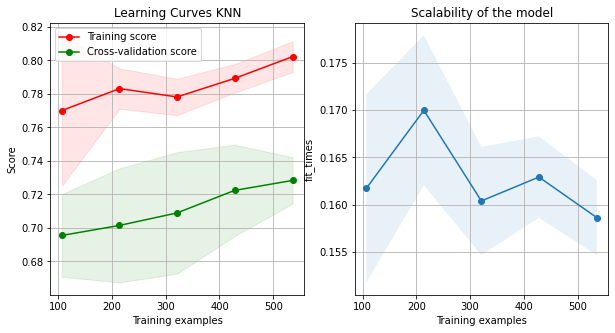

In [ ]:
# plot learning curves
# Notice that we are using the best estimator
plot_learning_curve(loaded_best_estimator_round2, 'Learning Curves KNN', X_train, y_train, n_jobs=-1)

In [ ]:
# Check the train scores
# to check the train scores we will use loaded best estinator

print(loaded_best_estimator_round2.score(X_train,y_train))

# check the cross validation score
# To check the cross validation score we need to use the loaded complete grid results

print(loaded_complete_grid_round2.best_score_)

0.8014925373134328
0.7283582089552239


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:442: UserWarning:

X does not have valid feature names, but KNeighborsClassifier was fitted with feature names



### Conclusion: 1) Model from round 2 seems to be doing better in terms of training score and CV score. With the number of neighbours being 8, the training score learning curve has a linear increase with respect to CV curve and hence maintaining scalability of the model

## **4**: Pipeline2

In this round, we will use a different pipeline. Create a pipeline with following steps:

1. 'rare_label_encoder' for categorical variables
2. 'DecisionTree_Encoder_encoder', variables= categorical+discrete,
3. 'log_transformer', variables = continuous
4. 'scalar',StandardScaler(), variables = continuous
5. KNeighborsClassifier())





## Pipeline2

In [ ]:
credit_risk_pipeline_2 = Pipeline([  


    ('rare_label_encoder',
      RareLabelEncoder(tol=0.05, n_categories=2, variables=categorical,
                           replace_with='Rare')),

    ('DecisionTree_Encoder_encoder',
      DecisionTreeEncoder(random_state=123,
                    encoding_method = 'arbitrary',
                    regression = False,
                    scoring = 'accuracy',
                    variables= categorical + discrete,
                    ignore_format=True)),

    ('log_transformer',
     LogTransformer(variables = continuous)), 
    
    ('scalar',
      SklearnTransformerWrapper(StandardScaler(), variables = continuous)),
    
    ('knn',
     KNeighborsClassifier())                        

])

In [ ]:
y_train

356    good
344    good
236     bad
699    good
424     bad
       ... 
124     bad
923    good
362    good
217    good
200    good
Name: class, Length: 670, dtype: category
Categories (2, object): ['good', 'bad']

## **5:** Hyperparameter Tuning - Round 3
- Let us repeat all the steps of round 1. **Again only tune n_neighbors**. Use values in the range (1, 10). Use step size of 1.


In [ ]:

param_grid_3 = { 'knn__n_neighbors':  range(1, 10, 1)}
    
model_2 = Pipeline([('knn', KNeighborsClassifier())])

# now we set up the grid search with cross-validation
grid_knn_3 = GridSearchCV(credit_risk_pipeline_2, param_grid_3,
                           cv=5, return_train_score= True)


In [ ]:
# fit the grid on training data 
grid_knn_3.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/feature_engine/encoding/rare_label.py:182: UserWarning:

The number of unique categories for variable own_telephone is less than that indicated in n_categories. Thus, all categories will be considered frequent

/usr/local/lib/python3.7/dist-packages/feature_engine/encoding/rare_label.py:182: UserWarning:

The number of unique categories for variable foreign_worker is less than that indicated in n_categories. Thus, all categories will be considered frequent

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:442: UserWarning:

X does not have valid feature names, but KNeighborsClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:442: UserWarning:

X does not have valid feature names, but KNeighborsClassifier was fitted with feature names

/usr/local/lib/python3.7/dist-packages/feature_engine/encoding/rare_label.py:182: UserWarning:

The number of unique categories for variable own_telephone is less th

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('rare_label_encoder',
                                        RareLabelEncoder(n_categories=2,
                                                         variables=['checking_status',
                                                                    'credit_history',
                                                                    'purpose',
                                                                    'savings_status',
                                                                    'employment',
                                                                    'personal_status',
                                                                    'other_parties',
                                                                    'property_magnitude',
                                                                    'other_payment_plans',
                                                                    'hous

In [ ]:
# check the best_parameters from GridSearchCv for your model
print(grid_knn_3.best_params_)

{'knn__n_neighbors': 9}


In [ ]:
# Here  save_model_folder is folder where I have saved models. Change that to appropriate location. 
# This variable is defined in section Mount Google Drive, Import Data

# specify the file to save the best estimator
file_best_estimator_round3 = save_model_folder / 'knn_round3_best_estimator.pkl'

# specify the file to save complete grid results
file_complete_grid_round3 = save_model_folder / 'knn_round3_complete_grid.pkl'

In [ ]:
# save the best estimator
joblib.dump(grid_knn_3.best_estimator_, file_best_estimator_round3)

# save complete grid results
joblib.dump(grid_knn_3, file_complete_grid_round3)

['/content/drive/MyDrive/HW/knn_round3_complete_grid.pkl']

In [ ]:
# load  the best estimator
loaded_best_estimator_round3 = joblib.load(file_best_estimator_round3)

# load complete grid results
loaded_complete_grid_round3 = joblib.load(file_complete_grid_round3)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

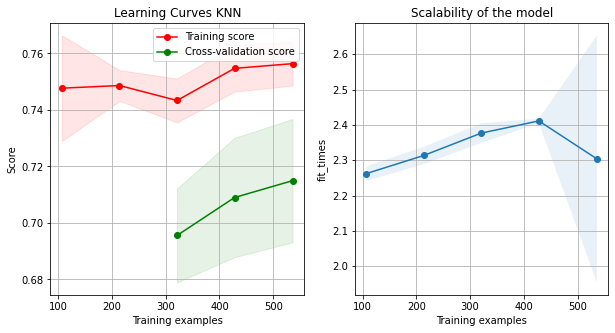

In [ ]:
# plot learning curves
# Notice that we are using the best estimator
plot_learning_curve(loaded_best_estimator_round3, 'Learning Curves KNN', X_train, y_train, n_jobs=-1)

In [ ]:
# Check the train scores
# to check the train scores we will use loaded best estinator

print(loaded_best_estimator_round3.score(X_train,y_train))

# check the cross validation score
# To check the cross validation score we need to use the loaded complete grid results

print(loaded_complete_grid_round3.best_score_)

0.753731343283582
0.7149253731343284


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:442: UserWarning:

X does not have valid feature names, but KNeighborsClassifier was fitted with feature names



# **6:** Performance on Test Data

In [ ]:
# check the test scores for final model
# Compare the cross validation score of round1, round2, and round3.
# Whichever round has best cross validation score, use the best estimator from that round to predict the test scores
print(f'Test data accuracy for round 2: { loaded_best_estimator_round2.score(X_test,y_test)}')


Test data accuracy for round 2: 0.7181818181818181


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:442: UserWarning:

X does not have valid feature names, but KNeighborsClassifier was fitted with feature names



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:442: UserWarning:

X does not have valid feature names, but KNeighborsClassifier was fitted with feature names



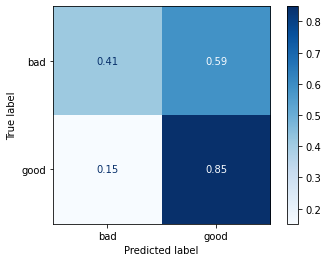

In [ ]:
# use the best estimator selected in previous step to plot the confusion matrix
plot_confusion_matrix(loaded_best_estimator_round2, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize = 'true')
plt.grid(False)
plt.show()

**Report the conclusion from confusion matrix.**

### Conclusion: 1) Model from round 2 seems to be doing good with accuracy 71% and number of neighbours as 8. 
### 2) From the above confusion matrix, it is seen that Recall value is 0.55
### Precision is 0.85 and Accuracy is 0.63
